# Time series

A time series is a set of observations $(x_t)_{t=1}^T$ where each $x_t$ is recorded at time $t$. Much data comes in the form of time series, such as e.g. much (macro-)economic data.

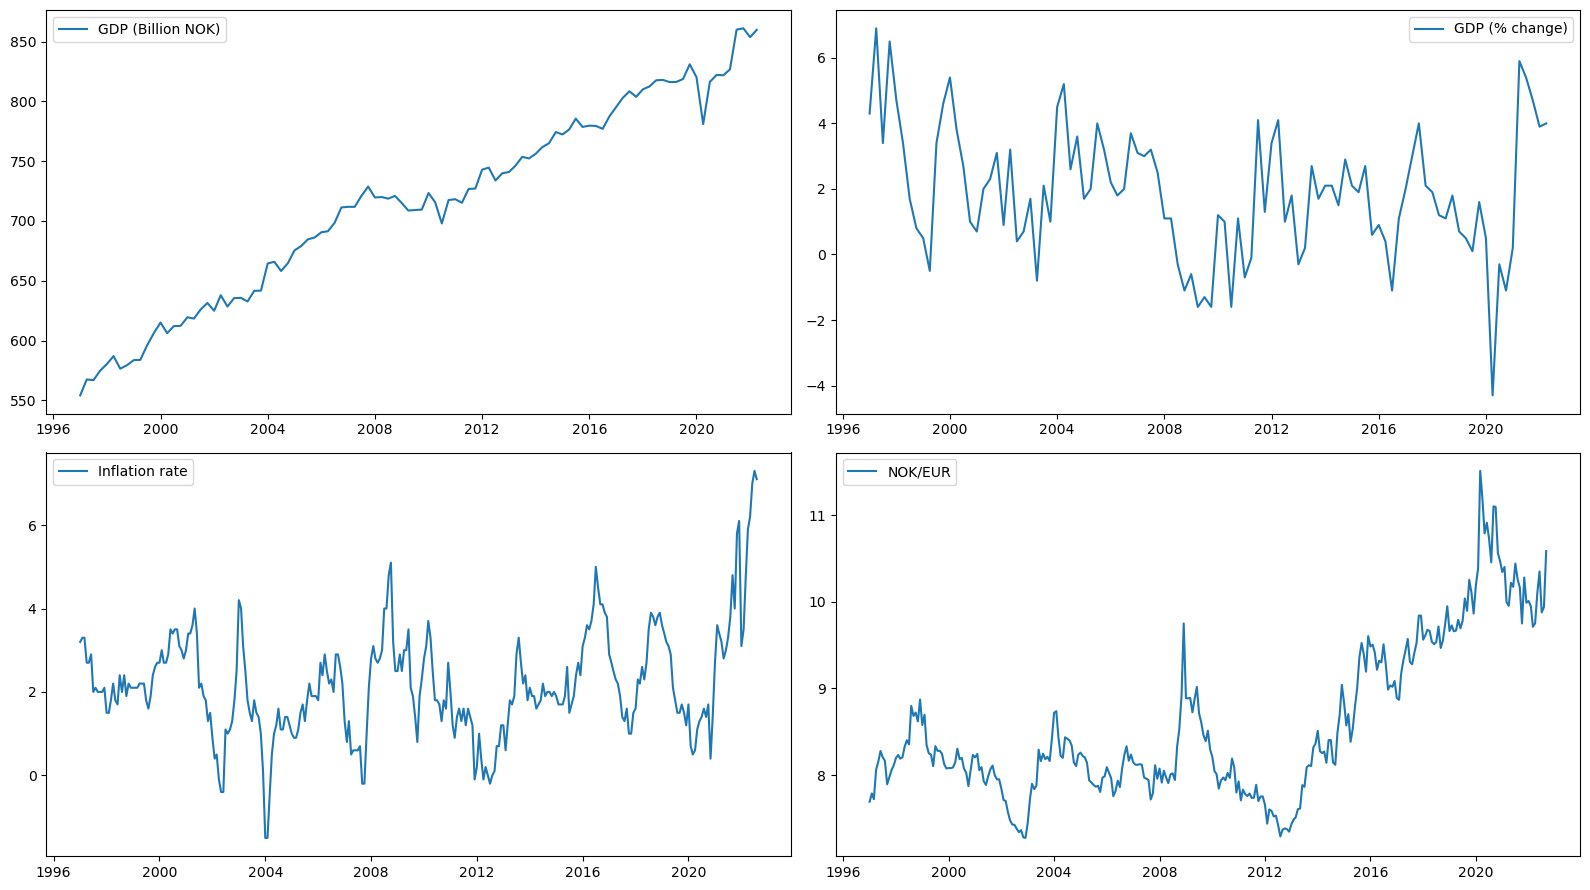

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Quarterly data
qdf = pd.read_csv(
    "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/namq_10_gdp.tsv.gz",
     sep=r'\,|\t',
     engine='python'
).rename(
    columns={'geo\\time':'geo'}
    ).query(
        "s_adj == 'SCA' & geo == 'NO' & (unit == 'CLV15_MNAC' | unit == 'CLV_PCH_SM') & na_item == 'B1GQ'"
        ).drop(
            ["s_adj", "na_item", "geo"],
             axis=1
             )

qdf = pd.melt(
    qdf,
    id_vars=['unit']
    ).rename(
        columns = {"variable":"date"}
        ).pivot(
            index = "date",
            columns = "unit",
            values = "value"
            )

qdf.index = pd.PeriodIndex(qdf.index.str.strip(), freq = "Q").to_timestamp()


# Monthly data

mdfs = [
    pd.read_csv("https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/prc_hicp_manr.tsv.gz",
                    sep=r'\,|\t',
                    engine='python'
                ).rename(
                    columns={'geo\\time':'geo'}
                    ).query(
                        "coicop == 'CP00' & geo == 'NO'"
                        ).drop(
                            ["unit", "geo"],
                            axis=1
                        ).melt(
                            id_vars= ["coicop"]
                            ).rename(
                                columns = {"variable":"date"}
                                ).pivot(
                            index = "date",
                            columns = "coicop",
                            values = "value"
                            ),
        pd.read_csv("https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/ert_bil_eur_m.tsv.gz",
                    sep=r'\,|\t',
                    engine='python'
                ).rename(
                    columns={'currency\\time':'geo'}
                    ).query(
                        "geo == 'NOK' & statinfo == 'END'"
                        ).drop(
                            ["statinfo", "unit"],
                            axis=1
                        ).melt(
                            id_vars= ["geo"]
                            ).rename(
                                columns = {"variable":"date"}
                                ).pivot(
                            index = "date",
                            columns = "geo",
                            values = "value"
                            )
]

for mdf in mdfs:
    mdf.index = pd.PeriodIndex(mdf.index.str.strip().str.replace("M", "-") + "-01", freq = "M").to_timestamp()

mdf = pd.concat(mdfs, join = "outer", axis = 1)



qdf_ind = qdf.index >= pd.to_datetime("1997-01-01")
mdf_ind = mdf.index >= pd.to_datetime("1997-01-01")

fig, axes = plt.subplots(2, 2, figsize = (16, 9))  

axes[0, 0].plot(qdf.index[qdf_ind], pd.to_numeric(qdf["CLV15_MNAC"][qdf_ind], errors = "coerce") / 1000, label = "GDP (Billion NOK)")
axes[0, 1].plot(qdf.index[qdf_ind], pd.to_numeric(qdf["CLV_PCH_SM"][qdf_ind], errors= "coerce"), label = "GDP (% change)")
axes[1, 0].plot(mdf.index[mdf_ind], pd.to_numeric(mdf["CP00"][mdf_ind], errors= "coerce"), label = "Inflation rate")
axes[1, 1].plot(mdf.index[mdf_ind], pd.to_numeric(mdf["NOK"][mdf_ind], errors = "coerce"), label = "NOK/EUR")

for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
plt.show()


Such data series are modelled by stochastic processes: that is, a family of random variables $(X_t)_{t\in \mathbb{Z}}$, where $x_t$ is thought of as the realisation of $X_t$.

Time series generally are _dependent_: past values influence future values. This is in marked constrast to the situation we have studied so far, where our observations were assumed to be _independent_.

Our main goal in this part of the course will be forecasting: we want to build models suitable for time series data, which we can use to forecast the value of the series at some point in the future.

We will have 4 lectures on time series, covering the following topics:

1. Stationarity
2. White noise and ARMA processes
3. Unit roots, random walks and ARIMA;
4. Forecasting;
5. Estimation of time series models

We will illustrate this by estimating a model to predict the inflation series above.

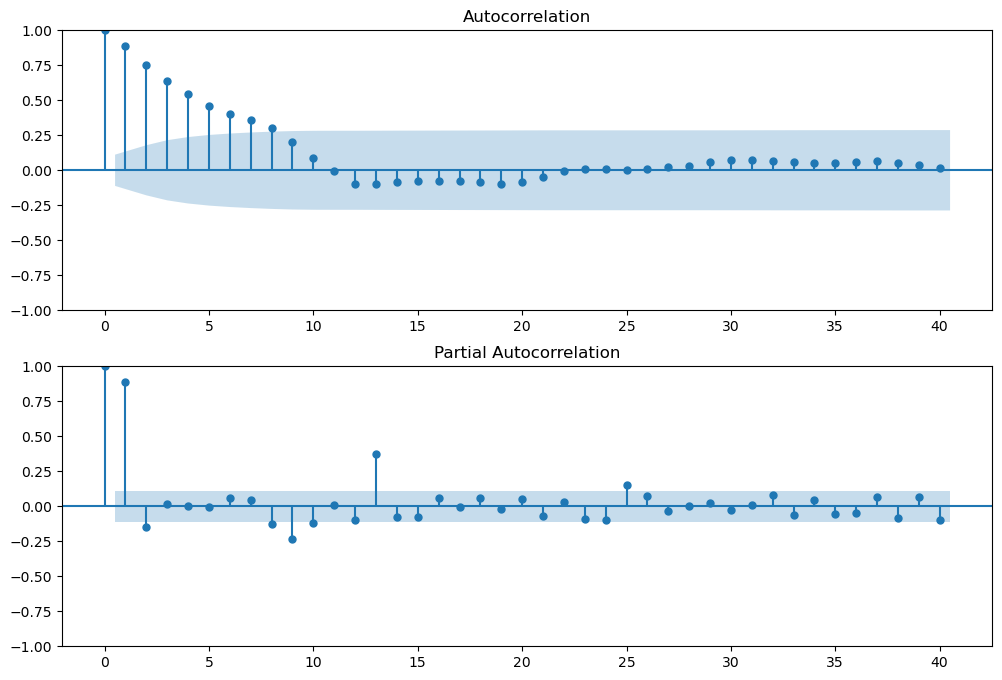

In [16]:
import statsmodels.api as sm
import statsmodels.tsa as smts

X = pd.to_numeric(mdf["CP00"][mdf_ind], errors= "coerce")[0:-1]

# Autocorelation and partial autocorrelation functions 

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X.values.squeeze(), lags=40, ax=ax2)

In [27]:
# Select lag order
mod =  smts.ar_model.ar_select_order(X, 12)
mod.bic

{(1, 2): 491.75587465207474,
 (1,): 492.420506547729,
 (1, 2, 3): 496.9656714661578,
 (1, 2, 3, 4): 502.6538185099581,
 (1, 2, 3, 4, 5): 508.28243884516223,
 (1, 2, 3, 4, 5, 6): 513.6149897440137,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 515.4599023376674,
 (1, 2, 3, 4, 5, 6, 7, 8): 517.9520280683258,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 519.1639758368481,
 (1, 2, 3, 4, 5, 6, 7): 519.2643197646985,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 520.8816465422415,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 526.19300963228,
 0: 1004.1609738313327}

In [28]:
# Estimate the model
res = mod.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   CP00   No. Observations:                  308
Model:                     AutoReg(2)   Log Likelihood                -242.347
Method:               Conditional MLE   S.D. of innovations              0.534
Date:                Fri, 14 Oct 2022   AIC                            492.694
Time:                        17:55:03   BIC                            507.589
Sample:                    03-01-1997   HQIC                           498.651
                         - 08-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2008      0.062      3.225      0.001       0.079       0.323
CP00.L1        1.0581      0.057     18.699      0.000       0.947       1.169
CP00.L2       -0.1463      0.058     -2.517      0.012      -0.260      -0.032
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1179           +0.0000j            1.1179            0.0000
AR.2            6.1150           +0.0000j            6.1150            0.0000
-----------------------------------------------------------------------------
"""

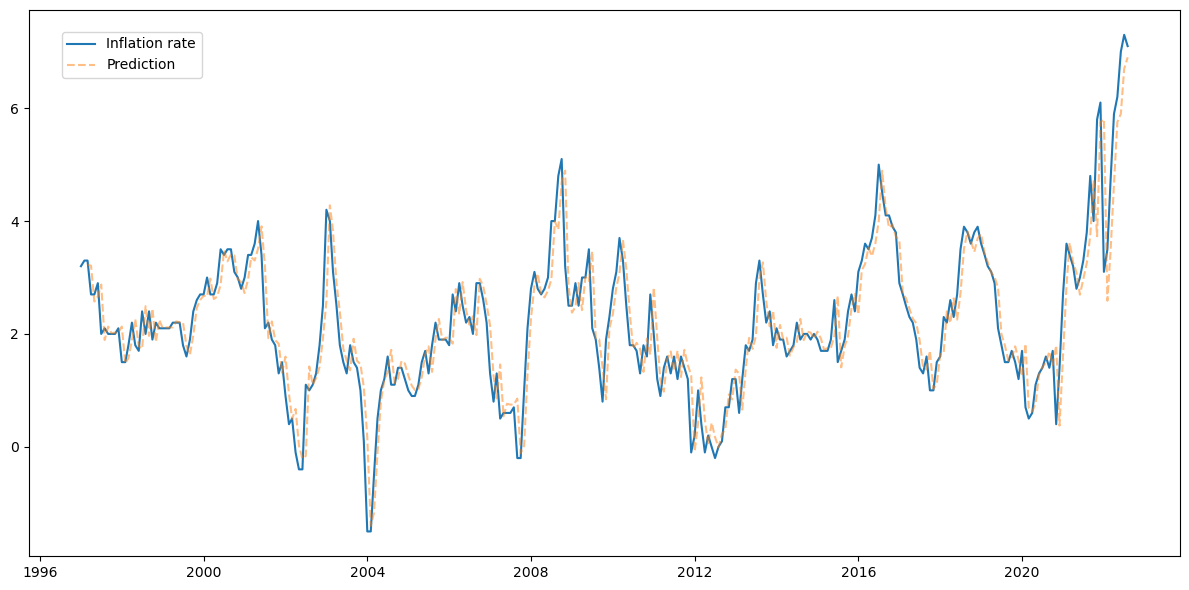

In [45]:
# Predict inflation (in - sample)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(X, label = "Inflation rate")
ax.plot(res.predict(), linestyle = "--", alpha =  0.5, label = "Prediction")
fig.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.95))
fig.tight_layout()
plt.show()
